### data import
- Data is downloaded and converted to pickle file
- [Download location](http://yann.lecun.com/exdb/mnist/)
- Extraction using mlxtend library. sample code [reference](http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/)

### code for importing and converting the data into pickle files

The original dataset as imported from website which contributes the dataset for public usage is in unsigned byte format. The dataset is in flattened format and has single channel 28\*28 images flattened row-wise. The images are rebuilt using one of the many codes contributed by various users working on the same dataset.

For ease of use, here we have converted the dataset to standard pickle format as the library is generally more readily available on most platforms when compared to the mlxtend library originally mentioned. 

```python
from mlxtend.data import loa local_mnist
import pickle as pkl

X, y = loadlocal_mnist(
        images_path='data/MNIST/train-images-idx3-ubyte', 
        labels_path='data/MNIST/train-labels-idx1-ubyte')

pkl.dump((X, y), open('data/MNIST/data.pkl', 'wb'))
```

In [5]:
!pip install mlxtend

     |████████████████████████████████| 1.3MB 122kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
from mlxtend.data import loadlocal_mnist
import pickle as pkl

X, y = loadlocal_mnist(
        images_path='data/MNIST/train-images-idx3-ubyte', 
        labels_path='data/MNIST/train-labels-idx1-ubyte')

pkl.dump((X, y), open('checkpoints/mnist/data.pkl', 'wb'))

In [2]:
import pickle as pkl

In [3]:
X, y = pkl.load(open('checkpoints/mnist/data.pkl', 'rb'))

In [4]:
X.shape, y.shape

((60000, 784), (60000,))

### Data Processing
- convert data to the appropriate format and check the label against sample instances for validation.
- data is presented in a single row vector as flattened values for 28\*28 images

In [5]:
import matplotlib.pyplot as plt
import random

### Validation Plot

Plotting dataset and checking corresponding labels to ensure validity of the code that is rebuilding the dataset from original ubyte dateset downloaded. The samples are picked at random to ensure that data at random are correctly labelled and the code is working fine in rebuilding the images from flattened vectors.

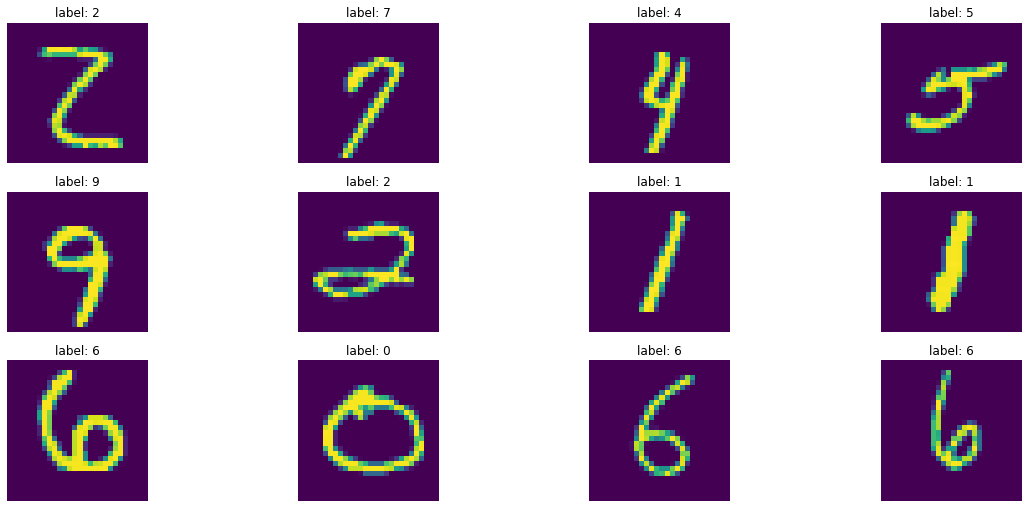

In [6]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    idx = random.randint(0, len(X)-1)
    image_row_vector = X[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### DCGAN

- Reference: https://github.com/pytorch/examples/blob/master/dcgan/main.py

Main idea of DCGAN lies in the terms of giving architecture guidelines to ensure stable training of GANs on CNNs. The main guidelines as summarized in the paper by the authors involve:

- replace any pooling layer with strided convolutions in discriminator and fractional-strided convolutions in generator
- batchnorm in both generator and discriminator
- no fully connected hidden layers in deep networks
- ReLU in generator for all layers but output layer which has Tanh activation
- LeakyReLU in discriminator for all layers

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torchsummary import summary

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")

print("DType: {}\nCuda available: {}\nDevice: {}".format(
    dtype.__str__(),
    torch.cuda.is_available().__str__(),
    device.__str__(),
))

DType: torch.float32
Cuda available: False
Device: cpu


### Bin count of Target Labels in the Dataset

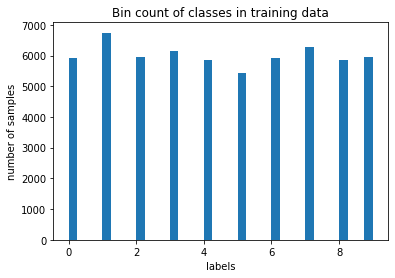

In [8]:
plt.hist(y, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in training data')
plt.show()

### Definition of Ally and Adversary Target Variables

Since there are not a explicit sensitive and preferred target variables in this particular dataset, I am sticking to creating custome target variables for the purpose of this experiment. 

In this case the adversary target variable would be to retrieve the exact label of the images while the ally would like to predict only whether it is an even or odd number.

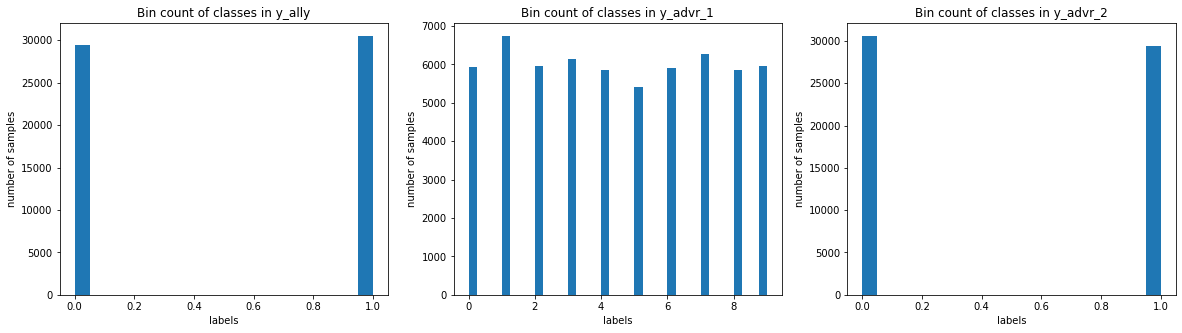

In [9]:
y_ally = y%2
y_advr_1 = y
y_advr_2 = y >= 5
y_advr_2 = y_advr_2.astype(int)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(y_ally, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in y_ally')
plt.subplot(1, 3, 2)
plt.hist(y_advr_1, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in y_advr_1')
plt.subplot(1, 3, 3)
plt.hist(y_advr_2, bins='auto')
plt.xlabel('labels')
plt.ylabel('number of samples')
plt.title('Bin count of classes in y_advr_2')
plt.show()

In [11]:
pkl.dump((X, y_ally, y_advr_1, y_advr_2), open('checkpoints/mnist/processed_data_X_y_ally_y_advr_y_advr_2.pkl', 'wb'))

### Train Test Split

In [14]:
y_advr_1.shape

(60000,)

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_ally_train, y_ally_valid, y_advr_1_train, y_advr_1_valid, y_advr_2_train, y_advr_2_valid = \
train_test_split(
    X, 
    y_ally,
    y_advr_1,
    y_advr_2,
    test_size=0.1,
    stratify=pd.DataFrame(np.concatenate((y_ally.reshape(-1, 1), y_advr_1.reshape(-1, 1), y_advr_2.reshape(-1, 1)), axis=1))
)
X_train.shape, X_valid.shape, y_ally_train.shape, y_ally_valid.shape, y_advr_1_train.shape, y_advr_1_valid.shape, y_advr_2_train.shape, y_advr_2_valid.shape

((54000, 784),
 (6000, 784),
 (54000,),
 (6000,),
 (54000,),
 (6000,),
 (54000,),
 (6000,))

### Validating the split

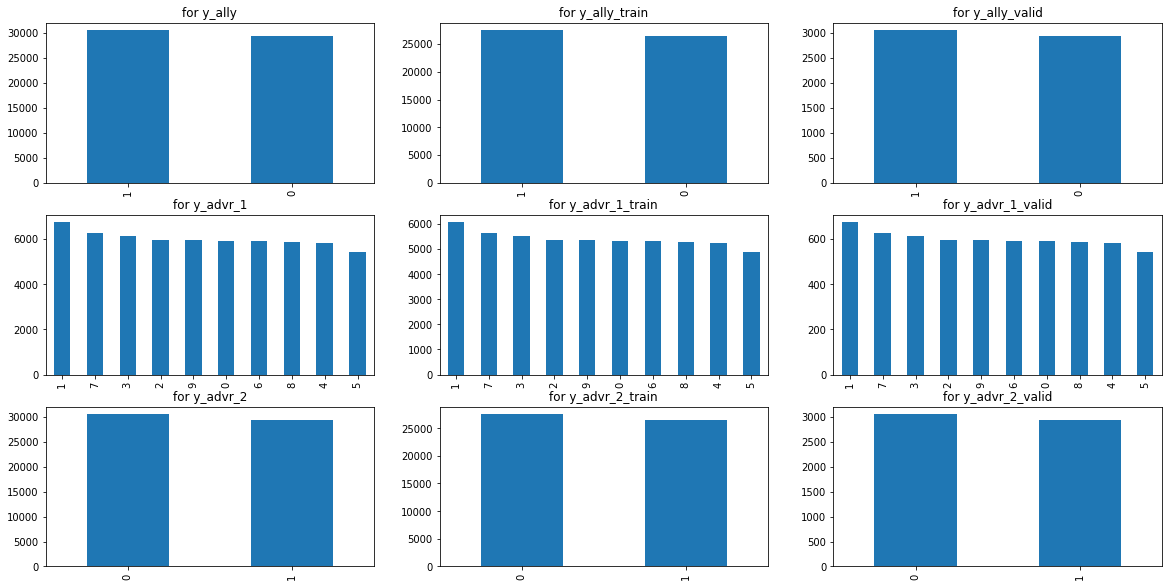

In [24]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 3, 1)
pd.value_counts(y_ally).plot(kind='bar')
plt.title('for y_ally')
plt.subplot(3, 3, 2)
pd.value_counts(y_ally_train).plot(kind='bar')
plt.title('for y_ally_train')
plt.subplot(3, 3, 3)
pd.value_counts(y_ally_valid).plot(kind='bar')
plt.title('for y_ally_valid')
plt.subplot(3, 3, 4)
pd.value_counts(y_advr_1).plot(kind='bar')
plt.title('for y_advr_1')
plt.subplot(3, 3, 5)
pd.value_counts(y_advr_1_train).plot(kind='bar')
plt.title('for y_advr_1_train')
plt.subplot(3, 3, 6)
pd.value_counts(y_advr_1_valid).plot(kind='bar')
plt.title('for y_advr_1_valid')
plt.subplot(3, 3, 7)
pd.value_counts(y_advr_2).plot(kind='bar')
plt.title('for y_advr_2')
plt.subplot(3, 3, 8)
pd.value_counts(y_advr_2_train).plot(kind='bar')
plt.title('for y_advr_2_train')
plt.subplot(3, 3, 9)
pd.value_counts(y_advr_2_valid).plot(kind='bar')
plt.title('for y_advr_2_valid')
plt.show()

### Scaling for Normalization

Ideally this should be done at a batch level for larger dataset but here since the providers give the entire dataset in a single matrix it is possible to do this scaling for the entire dataset at one go.

There can be various options for scaling which includes Standard Scaling as well. I have used MinMax Scaling because of the ease of use and it is generally shown to maintain the distribution and work well with outliers.

In [10]:
scaler = MinMaxScaler()
scaler.fit(X_train.astype(np.float64))
X_train_normalized = scaler.transform(X_train.astype(np.float64))
X_valid_normalized = scaler.transform(X_valid.astype(np.float64))
X_train_normalized.shape, X_valid_normalized.shape

((54000, 784), (6000, 784))

### Validation Plot

To check if the images are affected at all by any of the normalization techniques which might be applied in the previous step, we plot and check visually for randomly picked elements that the images maintain their structure as they would have in the original scale image.

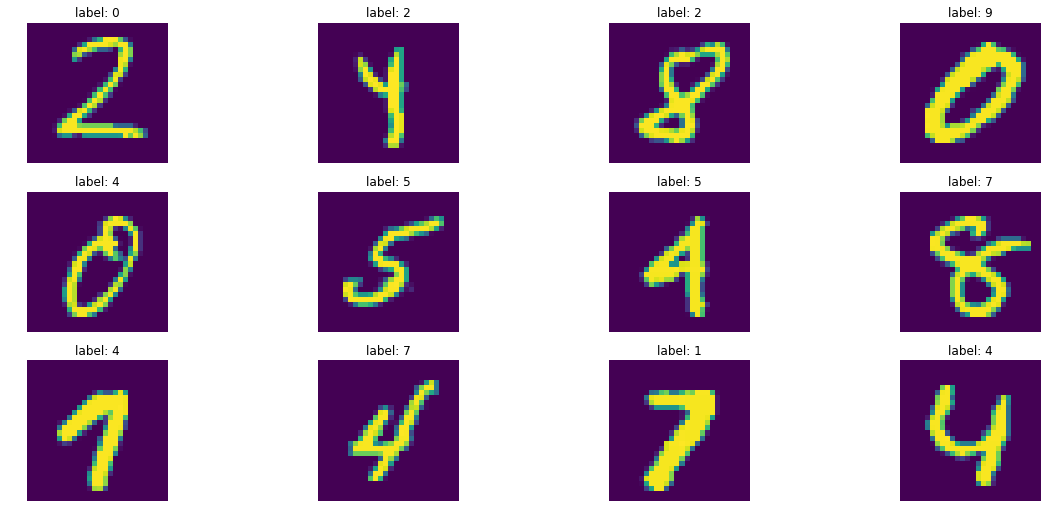

In [11]:
plt.figure(figsize=(20, 15))
for _ in range(12):
    if _ % 2 == 0:
        idx = random.randint(0, len(X_train)-1)
        image_row_vector = X_train_normalized[idx]
    else:
        idx = random.randint(0, len(X_valid)-1)
        image_row_vector = X_valid_normalized[idx]
    plt.subplot(5, 4, _+1)
    plt.imshow(image_row_vector.reshape((28, 28, 1)).squeeze())
    plt.title("label: {}".format(y[idx]))
    plt.axis('off')
plt.show()

### Apply PCA and select components using explained variances

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_reduced = pca.fit_transform(X_train_normalized)

num_components = 0
total_var = 0
variance_threshold = 0.99
for _ in pca.explained_variance_ratio_:
    total_var += _
    num_components += 1
    if total_var > variance_threshold:
        break
print(total_var, num_components)

0.9901009797616632 332


In [13]:
pca = PCA(n_components=num_components)
X_train_reduced = pca.fit_transform(X_train_normalized)
X_valid_reduced = pca.transform(X_valid_normalized)
X_train_reduced.shape, X_valid_reduced.shape

((54000, 332), (6000, 332))

### Convert To Torch Tensors

In [14]:
def to_categorical(y, num_classes=None, dtype='float32'):

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

y_advr_train = to_categorical(y_advr_train)
y_advr_valid = to_categorical(y_advr_valid)
y_advr_train.shape, y_advr_valid.shape

((54000, 10), (6000, 10))

In [15]:
y_ally_train = y_ally_train.reshape(-1, 1)
y_ally_valid = y_ally_valid.reshape(-1, 1)
y_ally_train.shape, y_ally_valid.shape

((54000, 1), (6000, 1))

### Apply Autoencoders

In [16]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.input_size = input_size
        self.encoding_dim = encoding_dim
        
        self.fc1 = torch.nn.Linear(self.input_size, self.encoding_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.encoding_dim, self.input_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def encoder(self, x):
        return self.relu(self.fc1(x))

    def decoder(self, y):
        return self.sigmoid(self.fc2(y))
    
    def forward(self, x):
        y = self.encoder(x)
        x = self.decoder(y)
        return x

In [17]:
auto_encoder = AutoEncoder(input_size=X_train_normalized.shape[1], encoding_dim=X_train_reduced.shape[1]).cuda()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam
ae_optimizer = optimizer(auto_encoder.parameters(), lr = 0.001)

summary(auto_encoder, input_size=(1, X_train_normalized.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 332]         260,620
              ReLU-2               [-1, 1, 332]               0
            Linear-3               [-1, 1, 784]         261,072
           Sigmoid-4               [-1, 1, 784]               0
Total params: 521,692
Trainable params: 521,692
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.99
Estimated Total Size (MB): 2.01
----------------------------------------------------------------


In [18]:
dataset_train = utils.TensorDataset(torch.Tensor(X_train_normalized))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(torch.Tensor(X_valid_normalized))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=True, num_workers=2)

In [19]:
print("epoch \t Aencoder_train \t Aencoder_valid")

auto_encoder.train()


ae_epoch = []
ae_train = []
ae_valid = []

for epoch in range(20):
    for i, data_train in enumerate(dataloader_train, 0):
        X_train_torch = data_train[0].to(device)
        ae_optimizer.zero_grad()

        X_train_torch_hat = auto_encoder(X_train_torch)
        ae_loss = criterion(X_train_torch_hat, X_train_torch)
        ae_loss.backward(retain_graph=True)
        ae_optimizer.step()

    nsamples = 0
    ae_valid_loss = 0
    for j, data_valid in enumerate(dataloader_valid, 0):
        X_valid_torch = data_valid[0].to(device)
        X_valid_torch_hat = auto_encoder(X_valid_torch)
        ae_valid_loss += criterion(X_valid_torch_hat, X_valid_torch)
        nsamples += 1

    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        ae_loss.item(),
        ae_valid_loss/nsamples
    ))
    
    ae_epoch.append(epoch)
    ae_train.append(ae_loss.item())
    ae_valid.append(ae_valid_loss/nsamples)

epoch 	 Aencoder_train 	 Aencoder_valid
0 	 0.02071283 	 0.02433280
1 	 0.01049942 	 0.01374196
2 	 0.00668922 	 0.00998540
3 	 0.00497524 	 0.00825935
4 	 0.00357861 	 0.00725502
5 	 0.00312692 	 0.00663366
6 	 0.00268212 	 0.00683052
7 	 0.00245785 	 0.00595653
8 	 0.00235202 	 0.00574397
9 	 0.00197639 	 0.00558074
10 	 0.00208734 	 0.00545401
11 	 0.00184565 	 0.00534202
12 	 0.00165530 	 0.00524219
13 	 0.00175937 	 0.00515041
14 	 0.00146922 	 0.00507949
15 	 0.00151983 	 0.00502441
16 	 0.00149767 	 0.00495385
17 	 0.00140512 	 0.00782281
18 	 0.00126922 	 0.00487513
19 	 0.00135537 	 0.00482781


- Convergence of autoencoded on this image dataset seems to be very accurate.
- Loss function used here is MLE instead of Crossentropy because it was showing better convergence.

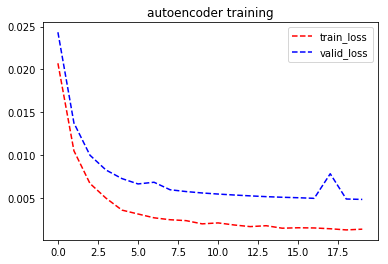

In [20]:
plt.plot(ae_epoch, ae_train, 'r--')
plt.plot(ae_epoch, ae_valid, 'b--')
plt.legend(['train_loss', 'valid_loss'])
plt.title("autoencoder training")
plt.show()

### Constants Explained

- nz: encoding dimension
- ngf: generator filters that are scaled by factors 2, 4, 8 etc.
- ndf: disciminator filter similar to ngf
- nc: number of channels
- ngpu: number of physical gpus on system
- batchSize: number of instances for SGD

In [21]:
nz = 50
ngf = 56
ndf = 56
nc = 1
ngpu = 1
batchSize = 512

### Weights and Bias Initialization

- It has been shown heuristically that weights intialized normally tend to perform better when compared to random initialization. So the first function tries to achieve this goal.

- In the definition of Generator and Discriminator, sometimes the number of strides, kernel_size and pooling is adjusted to meet the final size of the output desired. 

- It can be seen that there are no fully connected layers in both G and D
- Also batchnorm is applied on all layers 
- ReLU on each layer except output
- Tanh on output layer

In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        

- LeakyReLU on each layer
- BatchNorm on each layer
- Sigmoid in last layer to ensure probabilistic output 
- Sigmoid helps apply the BCE criterion at the end on the loss for optimizer
- BCE is binary cross-entropy loss function

In [23]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 2, 4, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 2, 4, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 2, 4, 2, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, X_train_reduced.shape[1], 2, 4, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).squeeze(2).squeeze(2)

In [24]:
class Ally(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Ally, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.sigmoid(output)
        return output

class Adversary(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Adversary, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.softmax = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        output = self.softmax(output)
        return output

In [67]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

summary(netG, input_size=(1, 28, 28))

netF = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
netF.apply(weights_init)
netE = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
netE.apply(weights_init)

summary(netF, input_size=(1, X_train_reduced.shape[1]))
summary(netE, input_size=(1, X_train_reduced.shape[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 56, 8, 8]             224
       BatchNorm2d-2             [-1, 56, 8, 8]             112
         LeakyReLU-3             [-1, 56, 8, 8]               0
            Conv2d-4            [-1, 112, 3, 3]          25,088
       BatchNorm2d-5            [-1, 112, 3, 3]             224
         LeakyReLU-6            [-1, 112, 3, 3]               0
            Conv2d-7            [-1, 224, 2, 2]         100,352
       BatchNorm2d-8            [-1, 224, 2, 2]             448
         LeakyReLU-9            [-1, 224, 2, 2]               0
           Conv2d-10            [-1, 332, 1, 1]         297,472
             Tanh-11            [-1, 332, 1, 1]               0
Total params: 423,920
Trainable params: 423,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [68]:
criterion = nn.BCEWithLogitsLoss()
crossentropy = nn.CrossEntropyLoss()

optimizerG = optim.Adam(netG.parameters(), lr=0.0001)
optimizerF = optim.Adam(netF.parameters(), lr=0.00001)
optimizerE = optim.Adam(netE.parameters(), lr=0.00001)

### Create dataset and load

- Fixing the batchsize after creating dataset

In [27]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)), 
    torch.Tensor(y_ally_train.reshape(-1, 1)), 
    torch.Tensor(y_advr_train.reshape(-1, 10))
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize,
                                         shuffle=True, num_workers=2)


dataset_valid = utils.TensorDataset(
    torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)),
    torch.Tensor(y_ally_train.reshape(-1, 1)),
    torch.Tensor(y_advr_train.reshape(-1, 10))
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize,
                                              shuffle=True, num_workers=2)

### Model Parameters

- need to tweak the values of learning rate for generator and discriminator
- if the value is not optimal, discriminator might converge too soon and then generator will collapse 
- so the parameter tweaking is a must to find the right balance

In [28]:
alpha = 0.5
netG.train()
netF.train()
netE.train()

Adversary(
  (fc1): Linear(in_features=332, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Sigmoid()
)

In [69]:
niter = 100
outf = 'result'

gan_epoch = []
gan_g_loss_train = []
gan_g_loss_valid = []
gan_f_loss_train = []
gan_f_loss_valid = []
gan_e_loss_train = []
gan_e_loss_valid = []

for epoch in range(niter):
    gan_epoch.append(epoch)
    for i in range(10):
        for i, data in enumerate(dataloader_train, 0):
            X_train_torch = data[0].to(device)
            y_ally_train_torch = data[1].to(device)
            y_advr_train_torch = data[2].to(device)

            optimizerG.zero_grad()
            # Forward pass
            X_train_encoded = netG(X_train_torch)
            y_ally_train_hat_torch = netF(X_train_encoded)
            y_advr_train_hat_torch = netE(X_train_encoded)
            # Compute Loss
            lossF = criterion(y_ally_train_hat_torch, y_ally_train_torch)
            lossE = crossentropy(y_advr_train_hat_torch, torch.argmax(y_advr_train_torch, 1))
            lossG = alpha * lossF - (1-alpha) * lossE
            # Backward pass
            lossG.backward()
            optimizerG.step()
            
    for i in range(1):  
        for i, data in enumerate(dataloader_train, 0):
            X_train_torch = data[0].to(device)
            y_ally_train_torch = data[1].to(device)
            y_advr_train_torch = data[2].to(device)

            optimizerF.zero_grad()
            X_train_encoded = netG(X_train_torch)
            y_ally_train_hat_torch = netF(X_train_encoded)
            lossF = criterion(y_ally_train_hat_torch, y_ally_train_torch)
            lossF.backward()
            optimizerF.step()

            optimizerE.zero_grad()
            X_train_encoded = netG(X_train_torch)
            y_advr_train_hat_torch = netE(X_train_encoded)
            lossE = crossentropy(y_advr_train_hat_torch, torch.argmax(y_advr_train_torch, 1))
            lossE.backward()
            optimizerE.step()
            
    for i, data in enumerate(dataloader_valid, 0):
        X_valid_torch = data[0].to(device)
        y_ally_valid_torch = data[1].to(device)
        y_advr_valid_torch = data[2].to(device)
        X_valid_encoded = netG(X_valid_torch)
        y_ally_valid_hat_torch = netF(X_valid_encoded)
        y_advr_valid_hat_torch = netE(X_valid_encoded)

        valid_lossF = criterion(y_ally_valid_hat_torch, y_ally_valid_torch)
        valid_lossE = crossentropy(y_advr_valid_hat_torch, torch.argmax(y_advr_valid_torch, 1))
        valid_lossG = alpha * valid_lossF -(1-alpha) * valid_lossE

    print('{} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossG.item(),
        valid_lossG.item(),
        lossF.item(), 
        valid_lossF.item(),
        lossE.item(),
        valid_lossE.item(),
    ))
    
    gan_g_loss_train.append(lossG.item())
    gan_g_loss_valid.append(valid_lossG.item())
    gan_f_loss_train.append(lossF.item())
    gan_f_loss_valid.append(valid_lossF.item())
    gan_e_loss_train.append(lossE.item())
    gan_e_loss_valid.append(valid_lossE.item())

0 	 -0.83034331 	 -0.82523632 	 0.68568468 	 0.69150877 	 2.32666850 	 2.34198141
1 	 -0.81590235 	 -0.81158233 	 0.69389361 	 0.68949133 	 2.30881500 	 2.31265593
2 	 -0.82266438 	 -0.80172658 	 0.69441265 	 0.69357228 	 2.31810546 	 2.29702544
3 	 -0.80980742 	 -0.80438346 	 0.69120187 	 0.69658506 	 2.31414104 	 2.30535197
4 	 -0.81259584 	 -0.80911303 	 0.69507486 	 0.69018728 	 2.30505371 	 2.30841327
5 	 -0.80943984 	 -0.80264747 	 0.69619948 	 0.69358253 	 2.30826497 	 2.29887748
6 	 -0.81114101 	 -0.80065989 	 0.69318062 	 0.69552451 	 2.30559874 	 2.29684424
7 	 -0.80667603 	 -0.80368996 	 0.69173449 	 0.69601482 	 2.30868578 	 2.30339479
8 	 -0.80276412 	 -0.80925858 	 0.69233096 	 0.69285536 	 2.30600715 	 2.31137252
9 	 -0.80477363 	 -0.80963635 	 0.69259268 	 0.69365364 	 2.30102777 	 2.31292629
10 	 -0.80575013 	 -0.80644244 	 0.69536120 	 0.69283760 	 2.29993844 	 2.30572248
11 	 -0.80468750 	 -0.80524802 	 0.69100386 	 0.69214940 	 2.30115986 	 2.30264544
12 	 -0.801761

99 	 -0.80280173 	 -0.80639029 	 0.69136369 	 0.69375491 	 2.30410790 	 2.30653548


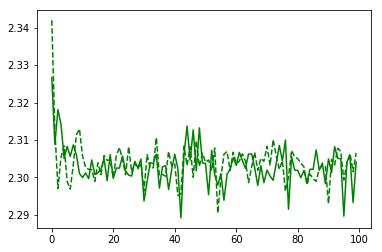

In [73]:
# plt.plot(gan_epoch, gan_g_loss_train, 'r')
# plt.plot(gan_epoch, gan_g_loss_valid, 'r--')
# plt.plot(gan_epoch, gan_f_loss_train, 'b')
# plt.plot(gan_epoch, gan_f_loss_valid, 'b--')
plt.plot(gan_epoch, gan_e_loss_train, 'g')
plt.plot(gan_epoch, gan_e_loss_valid, 'g--')
plt.show()

- Legend: 
    - red: encoder
    - blue: ally
    - green: adversary
- The variations are not very descriptive in the current scale of y axis. Trying to tweak model parameters to see if more variation and better convergence curve can be seen on the graph

### Save Model

In [ ]:
torch.save(netG, 'models/netG.pkl')
torch.save(netF, 'models/netF.pkl')
torch.save(netE, 'models/netE.pkl')

### Ally and Adversary Training on PCA Data

In [53]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_reduced), 
    torch.Tensor(y_ally_train.reshape(-1, 1)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_reduced), 
    torch.Tensor(y_ally_valid.reshape(-1, 1)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netF_pca = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerF = optim.Adam(netF_pca.parameters(), lr=0.001)
criterion = nn.BCELoss()


n_epoch = []
train = []
valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_ally_torch = data_train[1].to(device)
        
        optimizerF.zero_grad()
        
        y_train_ally_torch_hat = netF_pca(X_train_torch)

        lossF = criterion(y_train_ally_torch_hat, y_train_ally_torch)
        lossF.backward()
        
        optimizerF.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_ally_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netF_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_ally_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossF.item(),
        valid_loss,
    ))
    n_epoch.append(epoch)
    train.append(lossF.item())
    valid.append(valid_loss)
        

0 	 0.20759182 	 0.20116968
1 	 0.11039637 	 0.12983424
2 	 0.07544614 	 0.09974740
3 	 0.05814428 	 0.08518536
4 	 0.06338473 	 0.07588227
5 	 0.02939093 	 0.06927679
6 	 0.03892372 	 0.06567480
7 	 0.02105645 	 0.06198470
8 	 0.03787442 	 0.06004070
9 	 0.02305513 	 0.05611663
10 	 0.04846692 	 0.05639832
11 	 0.02719794 	 0.05595060
12 	 0.04092309 	 0.05314162
13 	 0.01665958 	 0.05290649
14 	 0.01638078 	 0.05253489
15 	 0.01903021 	 0.05196893
16 	 0.00806056 	 0.05273893
17 	 0.00947532 	 0.05372253
18 	 0.00704023 	 0.05375774
19 	 0.00981866 	 0.05338429


In [54]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_reduced), 
    torch.Tensor(y_advr_train.reshape(-1, 10)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_reduced), 
    torch.Tensor(y_advr_valid.reshape(-1, 10)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netE_pca = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerE = optim.Adam(netE_pca.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


train_a = []
valid_a = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        y_train_advr_torch = data_train[1].to(device)
        
        optimizerE.zero_grad()
        
        y_train_advr_torch_hat = netE_pca(X_train_torch)

        lossE = criterion(y_train_advr_torch_hat, torch.argmax(y_train_advr_torch, 1))
        lossE.backward()
        
        optimizerE.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        y_valid_advr_torch = data_valid[1].to(device)
        y_valid_advr_torch_hat = netE_pca(X_valid_torch)
        valid_l = criterion(y_valid_advr_torch_hat, torch.argmax(y_valid_advr_torch, 1))
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossE.item(),
        valid_loss,
    ))
    train_a.append(lossE.item())
    valid_a.append(valid_loss)

0 	 2.25720811 	 2.25508481
1 	 2.19376779 	 2.19444466
2 	 2.12817788 	 2.11675557
3 	 2.02324510 	 2.03033217
4 	 1.95800316 	 1.94709033
5 	 1.88218093 	 1.87325031
6 	 1.81654918 	 1.81351730
7 	 1.76706815 	 1.76594261
8 	 1.71784782 	 1.72959873
9 	 1.68626809 	 1.70026236
10 	 1.66258037 	 1.67814708
11 	 1.65589345 	 1.65987276
12 	 1.64337766 	 1.64488250
13 	 1.63204801 	 1.63282221
14 	 1.62614620 	 1.62252881
15 	 1.62883925 	 1.61340273
16 	 1.58146584 	 1.60626320
17 	 1.57746458 	 1.59888981
18 	 1.58316851 	 1.59343962
19 	 1.57574379 	 1.58870900


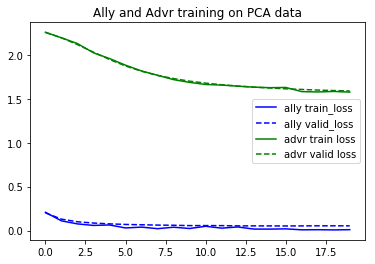

In [55]:
plt.plot(n_epoch, train, 'b')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, train_a, 'g')
plt.plot(n_epoch, valid_a, 'g--')
plt.legend([
    'ally train_loss', 
    'ally valid_loss', 
    'advr train loss', 
    'advr valid loss'
])
plt.title("Ally and Advr training on PCA data")
plt.show()

- The convergence on both ally and adversary is standard
- No signs of overfitting

### Ally and Adversary Training on AutoEncoder Data

In [63]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized), 
    torch.Tensor(y_ally_train.reshape(-1, 1)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_normalized), 
    torch.Tensor(y_ally_valid.reshape(-1, 1)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netF_pca = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerF = optim.Adam(netF_pca.parameters(), lr=0.001)
criterion = nn.BCELoss()


ae_ally_train=[]
ae_ally_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = auto_encoder.encoder(data_train[0].to(device))
        y_train_ally_torch = data_train[1].to(device)
        
        optimizerF.zero_grad()
        
        y_train_ally_torch_hat = netF_pca(X_train_torch)

        lossF = criterion(y_train_ally_torch_hat, y_train_ally_torch)
        lossF.backward()
        
        optimizerF.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = auto_encoder.encoder(data_valid[0].to(device))
        y_valid_ally_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netF_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_ally_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossF.item(),
        valid_loss,
    ))
    ae_ally_train.append(lossF.item())
    ae_ally_valid.append(valid_loss)

0 	 0.30924699 	 0.32068289
1 	 0.25224307 	 0.26330837
2 	 0.18409440 	 0.20437789
3 	 0.15409854 	 0.16525971
4 	 0.14983161 	 0.14321146
5 	 0.13817824 	 0.13265274
6 	 0.11311960 	 0.13621890
7 	 0.10162642 	 0.11370765
8 	 0.09047701 	 0.11274331
9 	 0.09307476 	 0.10247134
10 	 0.07886897 	 0.10095840
11 	 0.03312887 	 0.09200987
12 	 0.05779878 	 0.08979602
13 	 0.12204274 	 0.08518752
14 	 0.11207882 	 0.08456784
15 	 0.10072557 	 0.09182974
16 	 0.05914456 	 0.08314329
17 	 0.03733351 	 0.08414363
18 	 0.09542236 	 0.07533306
19 	 0.06837932 	 0.07474553


In [59]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized), 
    torch.Tensor(y_advr_train.reshape(-1, 10)),
)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_normalized), 
    torch.Tensor(y_advr_valid.reshape(-1, 10)),
)

dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batchSize, shuffle=True, num_workers=2)

netE_pca = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerE = optim.Adam(netE_pca.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


ae_advr_train = []
ae_advr_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = auto_encoder.encoder(data_train[0].to(device))
        y_train_advr_torch = data_train[1].to(device)
        
        optimizerE.zero_grad()
        
        y_train_advr_torch_hat = netE_pca(X_train_torch)

        lossE = criterion(y_train_advr_torch_hat, torch.argmax(y_train_advr_torch, 1))
        lossE.backward()
        
        optimizerE.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = auto_encoder.encoder(data_valid[0].to(device))
        y_valid_advr_torch = data_valid[1].to(device)
        y_valid_advr_torch_hat = netE_pca(X_valid_torch)
        valid_l = criterion(y_valid_advr_torch_hat, torch.argmax(y_valid_advr_torch, 1))
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossE.item(),
        valid_loss,
    ))
    ae_advr_train.append(lossE.item())
    ae_advr_valid.append(valid_loss)
        

0 	 2.01919699 	 2.02769931
1 	 1.83579719 	 1.85885895
2 	 1.77947056 	 1.77383403
3 	 1.72602105 	 1.72581347
4 	 1.71036720 	 1.69477652
5 	 1.64042926 	 1.67305732
6 	 1.66186059 	 1.65666908
7 	 1.63442242 	 1.64411558
8 	 1.64832878 	 1.63289210
9 	 1.59853816 	 1.62500992
10 	 1.60488284 	 1.61765598
11 	 1.58906245 	 1.61081453
12 	 1.61581337 	 1.60531670
13 	 1.61099231 	 1.60090817
14 	 1.59117651 	 1.59588360
15 	 1.57759964 	 1.59255781
16 	 1.58509135 	 1.58880213
17 	 1.58730268 	 1.58626710
18 	 1.59087563 	 1.58368480
19 	 1.58539855 	 1.58042869


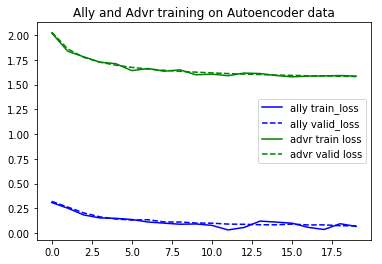

In [64]:
plt.plot(n_epoch, ae_ally_train, 'b')
plt.plot(n_epoch, ae_ally_valid, 'b--')
plt.plot(n_epoch, ae_advr_train, 'g')
plt.plot(n_epoch, ae_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

- Studying the graph we can see that the adversary is converging appropriately
- Ally network need model parameter tweaking to get rid of the divergence.

### Ally and Adversary training on Encoded Data

In [67]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)),
    torch.Tensor(y_ally_train.reshape(-1, 1)),
)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_normalized.reshape(-1, 1, 28, 28)),
    torch.Tensor(y_ally_valid.reshape(-1, 1)),
)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=True, num_workers=2)

netF_pca = Ally(X_train_reduced.shape[1], 128, y_ally_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerF = optim.Adam(netF_pca.parameters(), lr=0.00001)
criterion = nn.BCELoss()


gan_ally_train=[]
gan_ally_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        X_train_torch = netG(X_train_torch)
        y_train_ally_torch = data_train[1].to(device)
        
        optimizerF.zero_grad()
        
        y_train_ally_torch_hat = netF_pca(X_train_torch)

        lossF = criterion(y_train_ally_torch_hat, y_train_ally_torch)
        lossF.backward()
        
        optimizerF.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        X_valid_torch = netG(X_valid_torch)
        y_valid_ally_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netF_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_ally_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossF.item(),
        valid_loss,
    ))
    gan_ally_train.append(lossF.item())
    gan_ally_valid.append(valid_loss)

0 	 0.69288075 	 0.69301687
1 	 0.69201809 	 0.69305194
2 	 0.69288671 	 0.69304233
3 	 0.69412190 	 0.69303796
4 	 0.69380659 	 0.69302804
5 	 0.69102126 	 0.69298337
6 	 0.69341987 	 0.69300986
7 	 0.69332224 	 0.69297216
8 	 0.69238251 	 0.69298603
9 	 0.69397169 	 0.69295026
10 	 0.69297540 	 0.69304786
11 	 0.69418401 	 0.69303068
12 	 0.69110733 	 0.69306754
13 	 0.69336301 	 0.69301087
14 	 0.69272804 	 0.69302152
15 	 0.69265598 	 0.69312314
16 	 0.69257933 	 0.69301692
17 	 0.69344449 	 0.69299778
18 	 0.69436610 	 0.69303238
19 	 0.69381386 	 0.69303895


In [68]:
dataset_train = utils.TensorDataset(
    torch.Tensor(X_train_normalized.reshape(-1, 1, 28, 28)),
    torch.Tensor(y_advr_train.reshape(-1, 10)),
)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=2)

dataset_valid = utils.TensorDataset(
    torch.Tensor(X_valid_normalized.reshape(-1, 1, 28, 28)),
    torch.Tensor(y_advr_valid.reshape(-1, 10)),
)
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=256, shuffle=True, num_workers=2)

netE_pca = Adversary(X_train_reduced.shape[1], 128, y_advr_train.shape[1]).to(device)
# netF_pca.apply(weights_init)

optimizerE = optim.Adam(netE_pca.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()


gan_advr_train=[]
gan_advr_valid = []
for epoch in range(20):
    for i, data_train in enumerate(dataloader_train):
        X_train_torch = data_train[0].to(device)
        X_train_torch = netG(X_train_torch)
        y_train_advr_torch = data_train[1].to(device)
        
        optimizerE.zero_grad()
        
        y_train_ally_torch_hat = netE_pca(X_train_torch)

        lossE = criterion(y_train_ally_torch_hat, y_train_advr_torch)
        lossE.backward()
        
        optimizerE.step()
        
    nsamples = 0
    valid_loss = 0
    for i, data_valid in enumerate(dataloader_valid):
        X_valid_torch = data_valid[0].to(device)
        X_valid_torch = netG(X_valid_torch)
        y_valid_advr_torch = data_valid[1].to(device)
        y_valid_ally_torch_hat = netE_pca(X_valid_torch)
        valid_l = criterion(y_valid_ally_torch_hat, y_valid_advr_torch)
        valid_loss += valid_l.item()
        nsamples += 1
    valid_loss /= nsamples
        
    print('{} \t {:.8f} \t {:.8f}'.format(
        epoch, 
        lossE.item(),
        valid_loss,
    ))
    gan_advr_train.append(lossE.item())
    gan_advr_valid.append(valid_loss)

0 	 0.69329935 	 0.69329915
1 	 0.69320011 	 0.69319998
2 	 0.69317412 	 0.69317399
3 	 0.69316339 	 0.69316339
4 	 0.69315797 	 0.69315804
5 	 0.69315499 	 0.69315492
6 	 0.69315290 	 0.69315293
7 	 0.69315165 	 0.69315160
8 	 0.69315064 	 0.69315066
9 	 0.69315004 	 0.69314999
10 	 0.69314951 	 0.69314950
11 	 0.69314915 	 0.69314908
12 	 0.69314873 	 0.69314878
13 	 0.69314849 	 0.69314855
14 	 0.69314831 	 0.69314831
15 	 0.69314820 	 0.69314814
16 	 0.69314802 	 0.69314805
17 	 0.69314790 	 0.69314788
18 	 0.69314778 	 0.69314778
19 	 0.69314772 	 0.69314768


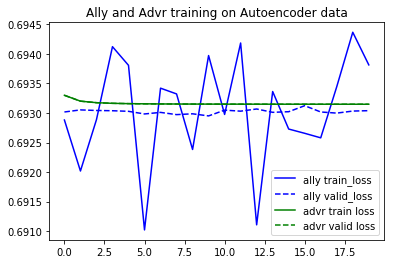

In [69]:
plt.plot(n_epoch, gan_ally_train, 'b')
plt.plot(n_epoch, gan_ally_valid, 'b--')
plt.plot(n_epoch, gan_advr_train, 'g')
plt.plot(n_epoch, gan_advr_valid, 'g--')
plt.legend(['ally train_loss', 'ally valid_loss', 'advr train loss', 'advr valid loss'])
plt.title("Ally and Advr training on Autoencoder data")
plt.show()

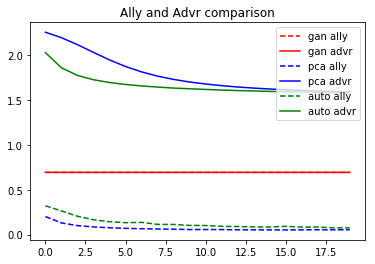

In [70]:
plt.plot(n_epoch, gan_ally_valid, 'r--')
plt.plot(n_epoch, gan_advr_valid, 'r')
plt.plot(n_epoch, valid, 'b--')
plt.plot(n_epoch, valid_a, 'b')
plt.plot(n_epoch, ae_ally_valid, 'g--')
plt.plot(n_epoch, ae_advr_valid, 'g')
plt.legend(['gan ally', 'gan advr', 'pca ally', 'pca advr', 'auto ally', 'auto advr'])
plt.title("Ally and Advr comparison")
plt.show()

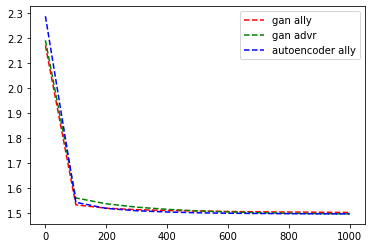

In [3]:
epochs = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

auto_ally = [0.65545598,0.54109581,0.52596698,0.51847158,0.51607584,0.51351950,0.51233711,0.51108771,0.51092901,0.51021491,0.50923452]
auto_advr = [2.19089735,1.56182141,1.53859117,1.52511171,1.51636479,1.51014968,1.50622827,1.50285327,1.50036708,1.49916746,1.49848810]
pca_ally =[0.70585175,0.52035322,0.51384263,0.51162118,0.51130803,0.51037628,0.51013036,0.51024503,0.50999505,0.50928623,0.50996693]
pca_advr = [2.28699915,1.54430321,1.52023215,1.51072041,1.50581849,1.50266080,1.50086851,1.49980764,1.49905597,1.49850315,1.49811943]
encd_ally = [0.63286703,0.51416672,0.51384061,0.51348210,0.51311324,0.51355186,0.51342442,0.51335753,0.51295490,0.51292664,0.51273378]
encd_advr = [2.17019427,1.53427020,1.52095829,1.51517934,1.51180234,1.50990692,1.50779183,1.50658275,1.50573009,1.50478715,1.50400517]

# plt.plot(epochs, encd_ally, 'r')
plt.plot(epochs, encd_advr, 'r--')
# plt.plot(epochs, auto_ally, 'g')
plt.plot(epochs, auto_advr, 'g--')
# plt.plot(epochs, pca_ally, 'b')
plt.plot(epochs, pca_advr, 'b--')
plt.legend([
    'gan ally', 'gan advr',
    'autoencoder ally', 'autoencoder advr',
    'pca ally', 'pca advr',
])

In [5]:
import matplotlib.pyplot as plt
import pickle as pkl

In [19]:
h2 = pkl.load(open('checkpoints/titanic/comparison_training_history_01_15_2020_04_27_22.pkl', 'rb'))
h1 = pkl.load(open('checkpoints/titanic/comparison_training_history_01_15_2020_00_17_48.pkl', 'rb'))

In [20]:
epochs = h2['epoch']['valid']
encd_ally = h2['encoder']['ally_valid']
encd_advr_1 = h2['encoder']['advr_1_valid']
encd_advr_2 = h2['encoder']['advr_2_valid']
auto_ally = h1['autoencoder']['ally_valid']
auto_advr_1 = h1['autoencoder']['advr_1_valid']
auto_advr_2 = h1['autoencoder']['advr_2_valid']
pca_ally = h1['pca']['ally_valid']
pca_advr_1 = h1['pca']['advr_1_valid']
pca_advr_2 = h1['pca']['advr_2_valid']

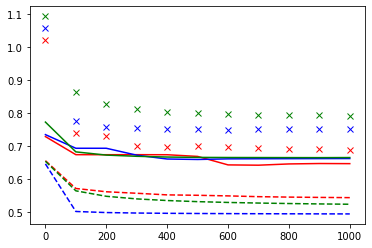

In [21]:
plt.plot(epochs, encd_ally, 'r')
plt.plot(epochs, encd_advr_1, 'r--')
plt.plot(epochs, encd_advr_2, 'rx')
plt.plot(epochs, auto_ally, 'b')
plt.plot(epochs, auto_advr_1, 'b--')
plt.plot(epochs, auto_advr_2, 'bx')
plt.plot(epochs, pca_ally, 'g')
plt.plot(epochs, pca_advr_1, 'g--')
plt.plot(epochs, pca_advr_2, 'gx')

Text(0.5, 1.0, 'Ally and advr comparison')

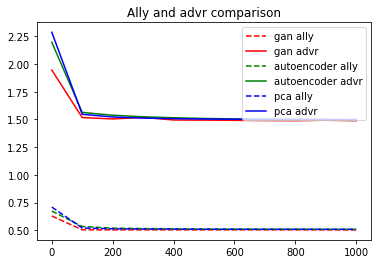

In [6]:
plt.plot(epochs, encd_ally, 'r--')
plt.plot(epochs, encd_advr, 'r')
plt.plot(epochs, auto_ally, 'g--')
plt.plot(epochs, auto_advr, 'g')
plt.plot(epochs, pca_ally, 'b--')
plt.plot(epochs, pca_advr, 'b')
plt.legend([
    'gan ally', 'gan advr',
    'autoencoder ally', 'autoencoder advr',
    'pca ally', 'pca advr',
])
plt.title('Ally and advr comparison')

In [20]:
import torch
import numpy as np

In [54]:
criterion = torch.nn.KLDivLoss()

In [78]:
a = torch.Tensor(np.array([1, 0, 0, 0, 0]))
b = torch.Tensor(np.log(np.array([0.6, 0.1, 0.1, 0.1, 0.1])))

In [79]:
criterion(b, a)

tensor(0.1022)

In [25]:
np.log10(0.5)

-0.3010299956639812

In [22]:
auto_1 = pkl.load(open('checkpoints/titanic/ind_autoencoder_training_history_01_16_2020_04_30_49.pkl', 'rb'))


In [23]:
auto_1

{'epoch': {'train': [], 'valid': []},
 'autoencoder': {'ally_train': [],
  'ally_valid': [],
  'advr_1_train': [],
  'advr_1_valid': [],
  'advr_2_train': [1.1215317249298096,
   1.1193069219589233,
   1.1170995235443115,
   1.1149098873138428,
   1.112740159034729,
   1.1105921268463135,
   1.108466386795044,
   1.1063637733459473,
   1.1042852401733398,
   1.102231740951538,
   1.1002050638198853,
   1.0982046127319336,
   1.0962307453155518,
   1.094284176826477,
   1.0923659801483154,
   1.0904779434204102,
   1.0886199474334717,
   1.0867918729782104,
   1.0849940776824951,
   1.0832282304763794,
   1.0814940929412842,
   1.0797927379608154,
   1.0781234502792358,
   1.0764869451522827,
   1.0748827457427979,
   1.0733100175857544,
   1.0717682838439941,
   1.0702569484710693,
   1.068777084350586,
   1.067327857017517,
   1.065908670425415,
   1.0645177364349365,
   1.0631558895111084,
   1.061822533607483,
   1.0605170726776123,
   1.0592385530471802,
   1.0579863786697388,
   1